BSAN 6300 Marketing Analytics
NLP Advanced Topics: BERT and Neural Network
By Zhen (Richard) Tang, Zhen.Tang@lmu.edu




This tutorial is developed for the 2021 Winter AMA pre-conference workshop on NLP in marketing research and for LMU's MSBA program.

The workshop is sponsered by the Interorganizational SIG.

In this tutorial, we will:
  * Familarize with BERT's contextualized enconding, with which we can transform raw texts into meaningful numerical respresentations. (**the texts to numbers step**)
  * Utilize BERT's embeddings to measure constructs of interests. (**the numbers to measures step**)  

The slides of this tutoria and a self-guided learning package of NLP are here [link text](https://drive.google.com/drive/folders/1hj0_t9v2vGYT2DkCUyx7CtKCo6Ar7uxe?usp=sharing)
  

In developing this tutorial, I cited codes from Chris McCormich and Nick Ryan ([link text](https://mccormickml.com/tutorials/)) and from Abhishek Kumar Mishra ([link text](https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb)).

For more tutorials on transfomer-based models, here is a wonderful Huggingface collecton ([link text](https://huggingface.co/transformers/v4.1.1/notebooks.html))

If you are interested in text mining without using neural networks, here ([link text](https://github.com/adashofdata/nlp-in-python-tutorial)) are some great tutorials.

## Load BERT








Install transformers, the interface for using BERT and other pre-trained models from Huggingface:https://huggingface.co/

In [ ]:
!pip install transformers
# per the setting of transformers, to use any of its NLP model
# we need to have three things: that is BertTokenizer, BertModel, BertConfig
import transformers
from transformers import BertTokenizer, BertModel, BertConfig

Import other utilities

In [ ]:
import torch
import numpy as np
import random
import pandas as pd
from scipy.spatial.distance import cosine
from scipy.stats.stats import pearsonr
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim


<ipython-input-2-69b216d5c386>:6: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [ ]:
# set the random set the same, making the results reproducible
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

GPU availability

In [ ]:
# let's see if we have access to GPU
# GPU is really good at parallel computation
from torch import cuda
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(device)


cuda


Create an instance of BERT model, and name it "**text_to_number**" becasue this model helps us tranform raw texts into numberical representations.
We will use this model later

In [ ]:
# note that it takes some time to download the BERT model (~ 440M)
# BERT model is big due to it huge amount of paramters.
text_to_number = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Creat an instance of BERT tokenizer, and name it "**tokenizer**"
We will use tokenizer to transform raw texts into right format to feed into **text_to_number**




In [ ]:
# as you can tell, the tokenizer is pretty small, only 232k in size
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## BERT Basics
Learning outcomes:
1. Use a BertTokenizer (i.e., our **tokenizer**) to transform raw texts into token ids and see how the tokenizer handles out of vocabulary(OOV) words.
2. Use the tokenizer.encode_plus() function to transform raw texts into proper formats (e.g., **input_ids** and **attention_mask**) to feed into a BERT model (i.e., **text_to_number**).
3. Use **text_to_number** to transform the examplary text into numerical reprentations and check the contextual encoding property.

### 1. Tokenizer
Use a BertTokenizer (i.e., our **tokenizer**) to transform raw texts into token ids and see how the tokenizer handles out of vocabulary(OOV) words.





Create an examplary sentence

In [ ]:
# note that the meanings of two "banks" are different
example = "After stealing money from the bank vault and learning NLP, the bank robber was seen fishing on the Mississippi river bank."


See how BERT handle out-of-vocbulary (OVV) words
  * OVV words are split into word pieces that are in the base dictionary of BERT;
therefore, BERT can handle any OVV words in a flexible and meaningful way
  * Questions: how do handle emoji? You know, to computer, emoji pictures are just embeddings/numerical vectors
    * Paper on training embedding system with emoji as tokens:http://ceur-ws.org/Vol-2491/short125.pdf

In [ ]:
# use tokenizer to convert raw input into token
tokenized_text = tokenizer.tokenize(example)
print(tokenized_text)

['after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', 'and', 'learning', 'nl', '##p', ',', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '.']


Note that NLP is splited into two tokens, "nl" and "##p", each of them will have a meaningful embedding, to which we can apply subsequent analysis like neural network classification.

In [ ]:
# some popular terms/brands/concepts are in BERT's basic vacabulary/token set
# thus, they will not be split.
test1 = 'zhen'
tokenized_text1 = tokenizer.tokenize(test1)
print(tokenized_text1)

['z', '##hen']


See how each token is correponding to an ID (**input_ids**) in BERT

In [ ]:
# convert token into input_id, which is the inputs that are fed into the BERT model
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
print(tokenized_text)
print(indexed_tokens)

['after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', 'and', 'learning', 'nl', '##p', ',', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '.']
[2044, 11065, 2769, 2013, 1996, 2924, 11632, 1998, 4083, 17953, 2361, 1010, 1996, 2924, 27307, 2001, 2464, 5645, 2006, 1996, 5900, 2314, 2924, 1012]


If you want to have a glimpse of BERT's base vacabulary/tokens

In [ ]:
# total size the base token pool
print(len(list(tokenizer.vocab.items())))
# get a snippet of pool
list(tokenizer.vocab.items())[1000:1050]

30522


[('"', 1000),
 ('#', 1001),
 ('$', 1002),
 ('%', 1003),
 ('&', 1004),
 ("'", 1005),
 ('(', 1006),
 (')', 1007),
 ('*', 1008),
 ('+', 1009),
 (',', 1010),
 ('-', 1011),
 ('.', 1012),
 ('/', 1013),
 ('0', 1014),
 ('1', 1015),
 ('2', 1016),
 ('3', 1017),
 ('4', 1018),
 ('5', 1019),
 ('6', 1020),
 ('7', 1021),
 ('8', 1022),
 ('9', 1023),
 (':', 1024),
 (';', 1025),
 ('<', 1026),
 ('=', 1027),
 ('>', 1028),
 ('?', 1029),
 ('@', 1030),
 ('[', 1031),
 ('\\', 1032),
 (']', 1033),
 ('^', 1034),
 ('_', 1035),
 ('`', 1036),
 ('a', 1037),
 ('b', 1038),
 ('c', 1039),
 ('d', 1040),
 ('e', 1041),
 ('f', 1042),
 ('g', 1043),
 ('h', 1044),
 ('i', 1045),
 ('j', 1046),
 ('k', 1047),
 ('l', 1048),
 ('m', 1049)]

### 2. Tokneizer.encode_plus
Use the tokenizer.encode_plus() function to transform raw texts into proper formats (e.g., **input_ids** and **attention_mask**) to feed into a BERT model (i.e., **text_to_number**).

learn the syntax of encode_plus
* it is critically important for us to understand the formats of the inputs and outputs of the function we use.
* for encode_plus fucntion
  * inputs include
    * raw texts
    * arguments like the maximum length (of the raw text to be processed); longer ones will be trancated, shorter ones will be padded.  
  * outputs include:
    * input_ids (IDs of tokens in the raw texts)
    * attention_mask (dummies for if the token is from raw texts or padded)
    * token_type_ids (IDs of sentences, not commonly used)
    * special tokens like [CLS], [SEP] are automatically added
      * [CLS] contains the summary information of the raw texts, and can be use in subsequant analysis.
      

In [ ]:
# see the syntax of encode_plus
tokenizer.encode_plus?

Object `tokenizer.encode_plus` not found.


In [ ]:
# trancate to max_length
# tranction argument tell the encode_plus from where to trancate the sentence beyond the specified max length, which is 20 in our case; maximum is 512
encoded_text = tokenizer.encode_plus(example, max_length = 8, truncation = 'longest_first', padding = 'max_length')
print(encoded_text)
# print the trancated tokens
print(tokenizer.convert_ids_to_tokens(encoded_text['input_ids']))

NameError: name 'tokenizer' is not defined

In [ ]:
# padding to another max_lenght, here let's use 48 so that we can see the padded tokens
encoded_text = tokenizer.encode_plus(example, max_length = 48, truncation = 'longest_first',padding = 'max_length')
print(encoded_text)
print(tokenizer.convert_ids_to_tokens(encoded_text['input_ids']))


**Recap:**

Tokenizer is a tool to pre-process the raw texts into **input_ids** and **attention_mask** that a BERT and other transformer-based NLP models take as inputs.  

### 3. BERT's Inputs and Outputs

Use our BERT model, **text_to_number** ,to transform the examplary text into numberical reprentations and check the contextual encoding property.





Set text_to_number into evaluation mode (e.g., do not do training) to save memory.

And please make sense of the structure of the model
  * In the firtt layer, the dimension of the raw word emeddings is (30522, 768), meaning that there is 30522 basic tokens in base BERT and each embeding has 768 features, i.e., 768-digit in the embedding vector
  * In subsequent layers, see the manefest of the self-attention mechanism, i.e., structure of query, key, and value

In [ ]:
# set the model into evaluation model to do feed-forward operation only, no training
text_to_number.eval()
# note that the first layer in BERT model is word_embedding layer
# with 30522 basic tokens in BERT's vocabulary and each token has an embedding with length of 768

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

2. Use the text_to_number model to transform the raw text. For the syntax of BERT Model, see: https://huggingface.co/transformers/model_doc/bert.html

In the codes below:
  * We set torch.no_grad(), so gradient will not be calcualted (calculating gradients only for training purpose) to save memory and imporve speed
  * Recall that encoded_text, which is derived from: encoded_text = tokenizer.encode_plus(example, max_length = 48, padding = 'max_length'), contains all the information we need to feed into text_to_number
    * Note that we need to convert the output of encoded_text into a pytorch tensor using **torch.tensor()** function so that pytorch could process it
    * Also note that input of BERT model need to have a batch dimension (i.e., we need to tell BERT how many sentences we feed into it); thus, we need to add one more dimension (representing the batch size) to the output of encoded_text function. Thus, we need to feed **[encoded_text['input_ids']]** instead of **encoded_text['input_ids']** in it



In [ ]:
print(torch.tensor([encoded_text['input_ids']]))
torch.tensor([encoded_text['input_ids']]).shape

tensor([[  101,  2044, 11065,  2769,  2013,  1996,  2924, 11632,  1998,  4083,
         17953,  2361,  1010,  1996,  2924, 27307,  2001,  2464,  5645,  2006,
          1996,  5900,  2314,  2924,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])


torch.Size([1, 48])

In [ ]:
# if you want to check the input format and shape
print(torch.tensor([encoded_text['input_ids']]))
torch.tensor([encoded_text['input_ids']]).shape

tensor([[  101,  2044, 11065,  2769,  2013,  1996,  2924, 11632,  1998,  4083,
         17953,  2361,  1010,  1996,  2924, 27307,  2001,  2464,  5645,  2006,
          1996,  5900,  2314,  2924,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])


torch.Size([1, 48])

In [ ]:
# this is the code for BERT model to generate word embeddings for us
with torch.no_grad():
  outputs  = text_to_number(input_ids = torch.tensor([encoded_text['input_ids']]),
                   attention_mask = torch.tensor([encoded_text['attention_mask']]), output_hidden_states = True)
last = outputs.last_hidden_state
pooler = outputs.pooler_output
all = outputs.hidden_states

Check the output format and shape (in our case, batch size = 1, # of tokens in the raw text = 48, specified by the max_len, hidden_sate_size = 768, given by base BERT model)
The first two outputs are given by default:
  * I call it "last": all embeddings in the last layer in the shape of (batch_size, max_length, hidden_state_size),
  * I call it "pooler": the pooler embedding ([CLS] token went through a linear layer and Tanh activation function) in the shape of (batch_size, hidden_state_size))
  * and with the output_hidden_states = True, we get the third input; I call it "all": the embeddings of all tokens from all self-attention layer in the shape of (# of layers, batch_size, max_length, hidden_state_size)

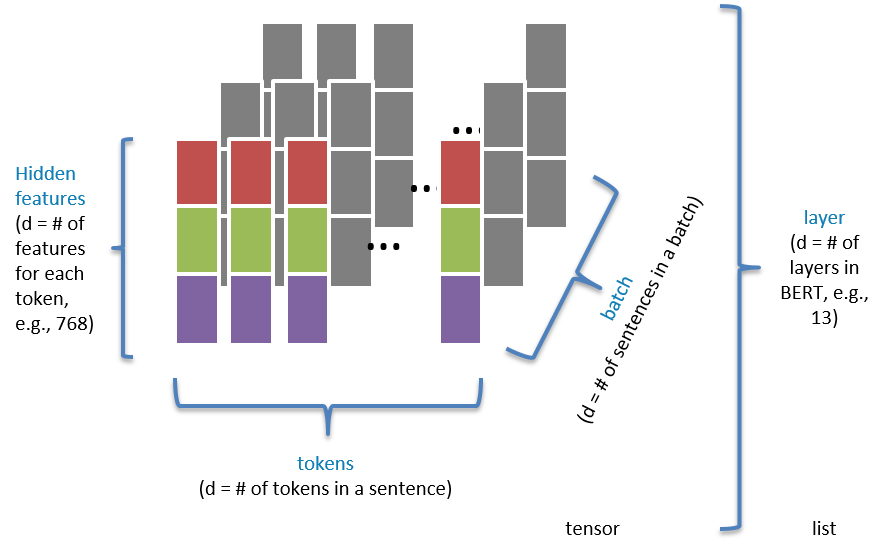

In [ ]:
# check the type and shape of the three outputs
print("the last layer output:", type(last), last.shape, "\n",
      "the pooler output:", type(pooler), pooler.shape, "\n",
      "the number of total layers:", type(all), len(all), "\n",
      "the output from the first layer:", type(all[0]), all[0].shape)

the last layer output: <class 'torch.Tensor'> torch.Size([1, 48, 768]) 
 the pooler output: <class 'torch.Tensor'> torch.Size([1, 768]) 
 the number of total layers: <class 'tuple'> 13 
 the output from the first layer: <class 'torch.Tensor'> torch.Size([1, 48, 768])


In [ ]:
# check if the output of BERT model consistent with setting
# the last layer of the "all" output should equal to the "last" output
last == all[12]

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

Understanding the structure of BERT output, we can then easily index and fetch the resultant word embeddings.

For instance, if we want to extract word embeddings from the last transformer layer.
  * Recall that the shape of "last" is (batch size, max_len, hidden size), in our case here is (1, 48, 768)

In [ ]:
# extract the word embeddings for non-padded input from last layer

# sum of attention_mask gives us the total number of non-padded token
print("embedding of all non-padded token from the last layer:", "\n",
      last[ :, 0 : sum(encoded_text['attention_mask']), :])

# check the shape/dimensions of all tokens
print("all tokens including padded ones:", last.shape)
# without the padded tokens
print("only tokens of raw input:", last[ :, 0 : sum(encoded_text['attention_mask']), :].shape)



embedding of all non-padded token from the last layer: 
 tensor([[[-0.7054, -0.2647, -0.5992,  ..., -0.0765,  0.3991,  0.3729],
         [-0.2369, -0.1814, -0.3718,  ..., -0.4018,  0.0893, -0.1481],
         [-0.3640, -0.3769,  0.1327,  ..., -0.1980, -0.0027, -0.1216],
         ...,
         [ 0.2506, -0.3052, -0.0736,  ..., -0.5509, -0.5678,  0.2074],
         [ 0.4868, -0.0969, -0.2821,  ...,  0.0487, -0.6154, -0.2020],
         [-0.7266, -0.6352, -0.3421,  ...,  0.3469, -0.0791, -0.6001]]])
all tokens including padded ones: torch.Size([1, 48, 768])
only tokens of raw input: torch.Size([1, 26, 768])


Can I use the mean of tokens' embeddigngs as the embedding of the sentence?
  * Yes. You have different ways to extract the sentence embeddings: http://jalammar.github.io/illustrated-bert/
  

In [ ]:
# torch.mean https://pytorch.org/docs/stable/torch.html#torch.mean
# note that you could use keep dim = True to keep the original dimension with batch size as the first axis
last[ :, 0 : sum(encoded_text['attention_mask']), :].mean(dim = 1)
# check its shape
last[ :, 0 : sum(encoded_text['attention_mask']), :].mean(dim = 1).shape

torch.Size([1, 768])

In [ ]:
# you can also extract the word embeddings from any other layer; let's call it layer "n" ; n is in (0, 12)
n = 9
all[n][ :, 0 : sum(encoded_text['attention_mask']), :]

tensor([[[-0.3416, -0.7685, -0.6851,  ..., -0.0671,  0.2427,  0.1223],
         [-0.2170, -0.2830, -0.5524,  ..., -0.6654, -0.0178, -0.1580],
         [-0.4943, -0.3955, -0.0968,  ..., -0.5568,  0.5050, -0.1994],
         ...,
         [ 0.5809, -0.0072, -0.2383,  ..., -0.5579, -0.2557,  0.2601],
         [-0.4215,  0.1235, -0.4502,  ..., -0.4727, -0.1443,  0.0363],
         [-0.0588, -0.0424,  0.0272,  ..., -0.0593,  0.0085, -0.0539]]])

Or, fetch the embeddings from the **pooler** output

In [ ]:
# poller has the [CLS] token that can be used for further classification
print(pooler)
print(pooler.shape)

tensor([[-6.0789e-01, -3.7445e-01, -6.1887e-01,  3.2762e-01,  4.9607e-01,
         -2.0008e-01,  3.6694e-01,  2.6268e-01, -3.2627e-01, -9.9986e-01,
         -2.8680e-01,  5.9604e-01,  9.8146e-01, -6.4765e-02,  7.8185e-01,
         -3.0816e-01, -2.7265e-02, -3.6798e-01,  1.0389e-01,  5.0773e-01,
          6.2830e-01,  9.9987e-01,  2.0951e-01,  2.3697e-01,  2.5235e-01,
          8.5642e-01, -5.2921e-01,  8.6322e-01,  8.9513e-01,  7.5573e-01,
         -1.5490e-01,  3.7787e-03, -9.8785e-01, -1.0600e-01, -7.5304e-01,
         -9.8067e-01,  1.7966e-01, -6.2294e-01,  1.7449e-01,  4.5779e-02,
         -7.6400e-01,  2.1437e-01,  9.9989e-01, -7.9633e-01,  4.6469e-01,
         -2.3993e-01, -9.9994e-01,  1.3767e-01, -8.0072e-01,  5.6016e-01,
          4.2001e-01,  7.3755e-01,  1.3418e-01,  2.8548e-01,  3.9192e-01,
         -2.3462e-01, -1.9785e-01,  4.7312e-02, -1.7071e-01, -4.9537e-01,
         -5.1865e-01,  1.5536e-01, -2.8353e-01, -7.7979e-01,  5.5050e-01,
          9.0547e-02, -4.0760e-02, -1.

Recap:

*   Inputs of BERT Model
> 1. input_ids: the ids of tokens in the raw texts.
> 2. attention_mask: the dummies mark if the token is from the raw texts or padded.
> 3. Apply the **encoder_plus** function to raw input gives you both vectors. Note that you need to extract them and transfor them into tensor before feeding into BERT model (as BERT model from transformer package only accept pytorch or tensorflow tensor)

*   Outputs of BERT Model
> 1. last layer embedding
> 2. pooler layer
> 3. output of all hidden self-attention layers with output_hidden_states = True

It is critical to understand the inputs and outputs of BERT model and their dimensionalities for us to use BERT's embddings in subsequent analysis.



### 4. BERT's contextual Embedding

We have learned the shape of inputs and outputs of BERT model. Then, let's extract the tokens of some specific words, see if their embeddings are more or less similar.

If so, we can confirm that BERT takes context into its encoding process.

For instance, in our example sentence, After stealing money from the **bank vault** and learning NLP, the **bank robber** was seen fishing on the Mississippi **river bank**, the embedding of "bank" in " bank vualt" should be more similar to that in "bank robber" then that in "river bank".

In [ ]:
# extract embedding of specific tokens: bank
# first get the index of the token
# encoded_text is the output of encode_plus, the "input_ids" is IDs of all raw word input
# tokenizer.convert_ids_to_tokens transfer the IDs into real words/tokens, which with we can find the words of our interests
# enumerate() create an iterable of the words with index
for i, token in enumerate(tokenizer.convert_ids_to_tokens(encoded_text["input_ids"])):
  print(i, token)

for i, token in enumerate(tokenizer.convert_ids_to_tokens(encoded_text["input_ids"])):
  if token == "bank":
    print("bank's position", i)

NameError: name 'tokenizer' is not defined

In [ ]:
# extract the embeddings for "bank" from the last layer
# accroding to the index about: the positions 6, 14, 23 is what we need
bank_vault = last[ :, 6, :]
bank_robber = last[ :, 14, :]
river_bank = last[:, 23, :]

NameError: name 'last' is not defined

In [ ]:
# check if the word "bank" in different contexts has different embeddings
river_bank == bank_robber

In [ ]:
# check if the three embeddings are in the same shape
print(bank_vault.shape, bank_robber.shape, river_bank.shape)

To analyze the similarity of the embeddings, we could do cosine similarity:
  * https://stackoverflow.com/questions/58381092/difference-between-cosine-similarity-and-cosine-distance

  * Cosine in scipy is calculating cosine distance, which is 1 - cosine similarity to get cosine similarity between A and B, we thus do 1 - cosine(A, B).
    * See reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html

In [ ]:
from scipy.spatial.distance import cosine
print("similarity between 'bank' in 'bank_vault' and 'bank_robber'", "\n", 1 - cosine(bank_vault.squeeze(), bank_robber.squeeze()))
print("similarity between 'bank' in 'bank_vault' and 'river_bank'", "\n", 1 - cosine(bank_vault.squeeze(), river_bank.squeeze()))
print("similarity between 'bank' in 'bank_robber' and 'river_bank'", "\n", 1 - cosine(bank_vault.squeeze(), river_bank.squeeze()))

In [ ]:
# alternatively, we can actully using pearson correlation to show the similarity between the embeddings
from scipy.stats.stats import pearsonr
print("similarity between 'bank' in 'bank_vault' and 'bank_robber'", "\n", pearsonr(bank_vault[0,:], bank_robber[0,:]))
print("similarity between 'bank' in 'bank_vault' and 'river_bank'", "\n", pearsonr(bank_vault[0,:], river_bank[0,:]))
print("similarity between 'bank' in 'bank_robber' and 'river_bank'", "\n", pearsonr(bank_vault[0,:], river_bank[0,:]))

Here is another fast way to show the capability of Transformer-based model in handling contextual information.

In [ ]:
# sentiment is a great interface that Huggingface developed based on BERT to analyze sentiment in the raw texts.
from transformers import pipeline
sentiment = pipeline('sentiment-analysis')


In [ ]:
# sentence 1: executed vs. terribly executed
result1a = sentiment('The capstone project plan was executed')
result1b = sentiment('The capstone project plan was terribly executed')
# sentence 2: good vs. with terribly good
result2a = sentiment('The capstone project plan was good')
result2b = sentiment('The capstone project plan was terribly good')

print("raw: The capstone project plan was executed", result1a, "\n", "with terribly: The capstone project plan was terribly executed", result1b)
print("raw: The capstone project plan was good", result2a, "\n", "with terribly: The capstone project plan was terribly good", result2b)
# note the different effects of "terribly" in the two pairs of sentences
# it changed the sentiment in the first one but not the second one,
# just as human being would do

**Recap:**
*   BERT is a encoding machine that generates numerical representation of raw texts.
*   BERT's embeddings are superior to thoes of previous encoding machines because BERT produces contextualized embeddings.




## Load the Raw Dataset
now, we've learned the input and output of BERT model. Let's explore how to incoporate BERT model into a traditional neural network and train the model to do the tasks we need.

but before that, let's first get the datasets we will work on.



In [ ]:
url = 'beauty_dataset_v1.csv'
raw_review = pd.read_csv(url)

In [ ]:
raw_review

,asin,text,numberOfHelpful,rating,reviewId,title,username,verified,country,date_new
0,B0973WGX3D,The media could not be loaded. Buyy it!!!! Ama...,0,5,R13DKMYTOTKWJX,Yessssss,Boss2021babe,True,United States,03-13-2022
1,B00DLJ7N2U,Item is heavy and uncomfortable after holding....,0,3,R1BT000GQYEISB,"Heavy, takes too long",Debbie Meadows,True,United States,04-07-2022
2,B00DLJ7N2U,So I was excited when I ordered this product. ...,0,1,R1VRRVSFGPZUPW,Not made for black women.,Candace,True,United States,04-07-2022
3,B00DLJ7N2U,My daughter purchased it and it was too painfu...,0,2,RDLUGW9NGVANK,Painful,Christina Martinez,True,United States,03-26-2022
4,B00DLJ7N2U,This can be used as maintenance between the tr...,2,3,RN9761C69LUKO,Not a replacement to the commercial treatments,Adrian,True,United States,03-24-2022
...,...,...,...,...,...,...,...,...,...,...
19367,B08N7VDKB8,We're going through a oily scalp phase over he...,0,5,R2ZS7LC9F7OP6I,My tweens love it,LazyUnicorn,True,United States,05-26-2021
19368,B08N7VDKB8,This dry shampoo works better than the others ...,0,5,R26IAPCYG9RHYV,Amazing product!,Mitz,True,United States,05-25-2021
19369,B08N7VDKB8,The Authentic Beauty Concept dry shampoo is a ...,0,5,R178PPASUDA561,"Works well, good travel size",Hunting Creek,True,United States,05-21-2021
19370,B08N7VDKB8,I don’t like the fact that it keeps saying ver...,3,1,R2T87E1H8RJ8SZ,Flammable information,Marcelina ponce,True,United States,05-19-2021


In [ ]:
# drop duplicated rows
print(raw_review.shape)
raw_review.drop_duplicates(subset = "text", inplace = True)
print(raw_review.shape)

# let's use only 1,2 or 4, 5 stars only
label_review = raw_review.loc[raw_review['rating']!=3, :]
print(label_review.shape)
label_review.rating.unique()

# define a function called label, with which we can assign label according to the value of rate
def label(row):
  if row['rating'] <= 2:
    value = 0
  else:
    value = 1
  return value

# use apply function to get the label function applied to each row of the label_review dataset
label_review['label'] = label_review.apply(label, axis = 1)

# create a balanced sample
good_review = label_review.loc[label_review['label'] == 1,:].sample(n = 2000)
bad_review = label_review.loc[label_review['label'] == 0, :].sample(n = 2000)
raw_text = pd.concat([good_review, bad_review])


(19372, 10)
(19372, 10)
(18067, 10)


<ipython-input-35-e84aa51f62a1>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_review['label'] = label_review.apply(label, axis = 1)


In [ ]:
# first of all, let's input the data
# text is the raw textual input we need process, label is the target of our classification task
raw_text1=raw_text[['label','text']]
raw_text1.head()

,label,text
16705,1,"Super nice, feels good in the shower!"
3001,1,This is so refreshing. I use it throughout the...
873,1,Very easy to use. Nice and smooth feeling for ...
5116,1,Great product! Smells good!
19314,1,Got this for my granddaughter who dances for a...


In [ ]:
# drop duplicated rows
print(raw_text1.shape)
raw_text1.drop_duplicates(subset = "text", inplace = True)
print(raw_text1.shape)

(4000, 2)
(4000, 2)


<ipython-input-37-05010dbdf113>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_text1.drop_duplicates(subset = "text", inplace = True)


In [ ]:
# create a balanced sample
label_review = raw_text1
good_review = label_review.loc[label_review['label'] == 1,:].sample(n = 2000)
bad_review = label_review.loc[label_review['label'] == 0, :].sample(n = 2000)
raw_text1 = pd.concat([good_review, bad_review])

In [ ]:
raw_text1.describe()

,label
count,4000.000000
mean,0.500000
std,0.500063
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
raw_text1.isna().sum()
raw_text1 = raw_text1.dropna()

In [ ]:
#spot checking dataframe
raw_text1.iloc[11:20,:]

,label,text
16020,1,I used the defoliator for the first time and I...
7534,1,ONLY giving it four stars because it hasn’t be...
6405,1,I finally found the mascara I've been searchin...
14429,1,These pretty hair scrunchies are perfect for m...
15717,1,I have never been able to find something that ...
6332,1,I bought this because I am having allergic rea...
6821,1,Very cute
17579,1,I was skeptical after some irritating experien...
15691,1,I struggle with bad ingrown hairs and exfoliat...


**Recap:**
Now, we got the dataset ready, we then could start to train a BERT + Neural Network Classification model, here are some main steps:
1.   Create an instance of Dataset and Dataloader to pre-process the data before feed it into a neural network
2.   Create a neural network
3.   Set up the loop for training and validating the model




## Customized Dataset Class and Dataloader
Next Steps:
* Get Raw Dataset
* Feed the Raw Dataset into a Neural Network (NN) for Classification
  * Layer 1 of the NN: text_to_number to transfer raw texts into numerical vector



### 1. Create a customized dataset
  * To save GPU RAM, we could not dump all raw data into GUP; we can only feed in samll batches. Thus, we need to utilize two functions **Dataset** and **Dataloader** to pre-process the raw data and schedule them into batches.

In [ ]:
# import the libraries we need
import numpy as np
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

Here we want to  create a customized Dataset--TextDataset--which could take a raw texts as inputs and encode them in BERT's way with a tokenizer.

The embeded inputs will be then fed into a BERT Model in the NN, which we will create later

To learn more about Dataset and Dataloader: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
class TextDataset(Dataset):

  # __init__ is a built-in function that defines some necessary attributes for any instance created
  # such as: the dataset with raw text reviews, what tokenizer we want to use for encoding,
  # the max length of sentence we need to pad or trancate
  def __init__(self, dataset, tokenizer, max_len):
    self.tokenizer = tokenizer
    self.data = dataset
    self.text = dataset.text
    self.label = dataset.label
    self.max_len = max_len

  def __len__(self):
    return len(self.text)


  def __getitem__(self, index):
    # __getitem__ is another built-in fucntion take 'index' (e.g., row id) as input,
    # in general/without customizatin, it returns the sample of a specific index in the dataset
    # further we could customize its functionality,
    # making it apply some operations on sample of the specific index
    # here we use index to locate a specific raw text we want to pre-process
    text = self.text.iloc[index]

    # then, we put the text into a BERT's encode_plus function
    # important debug tips:
    # for encode_plus, to keep all the raw inputs in the same length
    # we need to specify BOTH padding and trancation in addition to max_length
    # the former for short sentences and the latter for long ones
    # failing to do either one will result in uneven lengths of encoded inputs,
    # which will create troubles for your Dataloader in the NN training sessions
    outputs = self.tokenizer.encode_plus(
        text,
        max_length = self.max_len,
        padding = "max_length",
        truncation = "longest_first",
        # note that in some versions of transformer in you local machine, the code should be
        # pad_to_max_length = True,
        # truncation_strategy = 'longest_first',
        # we might need to change the argument name a little to fit different version of transformers
        add_special_tokens = True,
        return_tensors = 'pt'
    )


    # recall the BERT Tokenizer session, it takes raw text as input
    # and return input_ids, attention_mask as inputs for BERT model
    input_ids = outputs['input_ids']
    attention_mask = outputs['attention_mask']
    # we then store those values and put them together with the label info (the truth we want to predict) in the sample
    # as the return of the __getitem__ method
    # note that we use torch.tensor() function to make the vectors above into tensors
    return {
        'input_ids': torch.tensor(input_ids, dtype = torch.long),
        'attention_mask': torch.tensor(attention_mask, dtype = torch.long),
        'label': torch.tensor(self.label.iloc[index], dtype = torch.float)
    }




After create a customized Dataset class **TextDataset** to pre-process the raw data for neural network training. We need then:
  * Split raw data into the train and validate dataset
  * Feed the raw train and validation datasets into TextDataset to get pre-processed train and validation datasets
  * Feed the pre-processed train and validation datasets into a Dataloader to create the schedule to feed them into the neural network whoes first layer is a BERT model (i.e., text_to_number).




### 2. Split the raw dataset
Split raw data into the train and validate dataset

In [ ]:
# test_size argument in the function specify the percentage dividion between train and test datasets.
from sklearn.model_selection import train_test_split
train_raw, valid_raw = train_test_split(raw_text1, test_size = 0.1)

### 3. Feed Data into TextDataset
Feed the raw train and validation datasets into TextDataset to get pre-processed train and validation datasets

In [ ]:
# first let's define some key parameters we will use later
# maximum length of raw text to be processed
max_length = 64
# bath size (# of raw inputs) for training and validation
train_batch = 64
valid_batch = 32

# tpis: set the values of key parameters at the very begining and define them only once

In [ ]:
# create instances of the TextDataset for raw trianing and validate datasets
# recall that tokenizer has be defined by: tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') in the BERT tokenizer session
train_processed = TextDataset(train_raw, tokenizer, max_length)
valid_processed = TextDataset(valid_raw, tokenizer, max_length)

In [ ]:
# compare the raw and pre-processed data
# in this case, we fetch the observation with index = 10
# see the raw text
print(valid_processed.data.iloc[10, ])
# see the pre-processed text, i.e., the raw text input is tokenized)
print(valid_processed.__getitem__(10))

label                                                    1
text     Adds volume & thickness with one or two coats....
Name: 5687, dtype: object
{'input_ids': tensor([[  101,  9909,  3872,  1004, 14983,  2007,  2028,  2030,  2048, 15695,
          1012,  1045,  2123,  1005,  1056,  9378,  2026,  3239,  5789,  2125,
          2169,  2305,  1010,  2000,  3828,  2026,  3239,  2181,  2013,  2062,
         23277, 28562,  1010,  2061,  1045,  3543,  2039,  1996, 27700,  1996,
          2279,  2154,  1012,  1045,  2298,  2005, 19013,  1010, 12379, 27700,
          1010,  2061,  1045,  2064,  3543,  2009,  2039,  1996,  2279,  2154,
          1010,  1998,  2025,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'label': tensor(1.)}


<ipython-input-43-0a9305b5c0ef>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(input_ids, dtype = torch.long),
<ipython-input-43-0a9305b5c0ef>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(attention_mask, dtype = torch.long),


### 4. Feed data into dataloader
Feed the pre-processed train and validation datasets into a Dataloader to create the schedule to feed them into the neural network whoes first layer is a BERT model (i.e., text_to_number).


In [ ]:
# lastly, set up the dataloader that serves as a pipeline feeding pre-processed data into the neural network
# the process needs to specify a sampler first
train_sampler = RandomSampler(train_processed)
train_loader = DataLoader(train_processed, sampler = train_sampler, batch_size = train_batch, num_workers = 0)
valid_sampler = SequentialSampler(valid_processed)
valid_loader = DataLoader(valid_processed, sampler = valid_sampler, batch_size = valid_batch, num_workers = 0)

In [ ]:
# explore the attributes of dataloder
# length of dataloader = len(dataset)/batch size
print(len(train_loader))
print(len(valid_loader))


57
13



**Recap:**
  * Up to now, we have defined a customized Dataset instance to pre-process the raw input, encoding them into input_ids and attention_mask that BERT model needs.

  * We also set up the Dataloader that feed the pre-processed data into the neural network we are about create now.

## Define a Neural Network
Define a customized neural network with the first hidden layer being a BERT encoding layer to transform raw text into numerical representations.

The visualization below helps you understand the structure of the program.


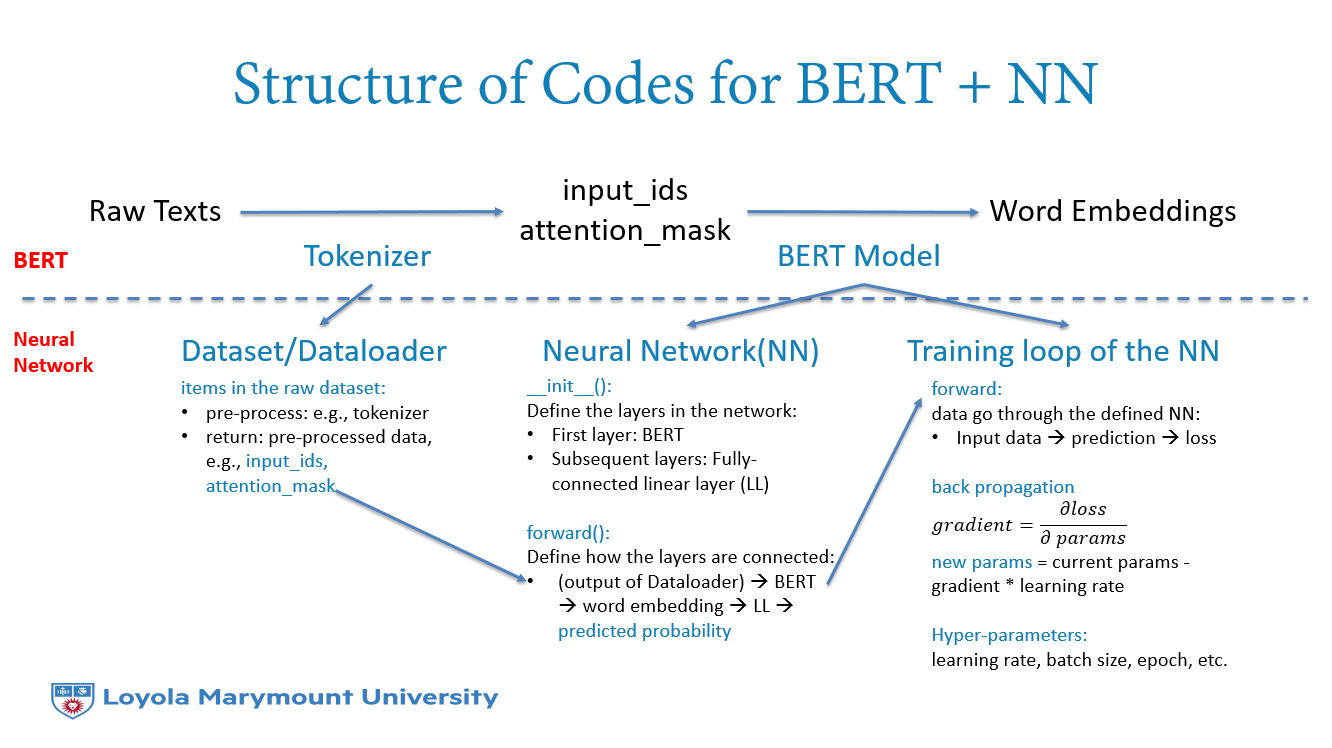

In [ ]:
# import the functions we need use in the neural network Model
import torch.nn.functional as F

In [ ]:
# the neural network we create is a class called  TextBERT, which inherits
# the attributes and structures of the torch.nn.Module

# the __init__ functino defines the necessary hidden layers of the NN
# and the forward function set up the computation graph: the real calculation procedures of the NN
class TextBERT(torch.nn.Module):
  def __init__(self):
    super(TextBERT, self).__init__()
    # the first layer is the BERT Model layer
    # recall that, we have defined model as: text_to_number = BertModel.from_pretrained('bert-base-uncased')
    # see BERT Model's input and output: https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    self.l1 = text_to_number

    # the fully connected last layer
    self.l2 = torch.nn.Linear(768, 1)

  def forward(self, input_ids, attention_mask):
    # first layer
    # the first layer utilize the BERT model (call "text_to_number" in __init__) to transfer the input_ids into
    # contextualized word embeddings --numerical vectors
    # we have different ways to use outputs of this layer,
    # such as using the [CLS] token or the mean of all input tokens
    # recall the BERT's inputs and outputs section for indexing and fetching various BERT model's outputs

    # if you want to use the BERT output of the last self-attention layer, do this:
    last = self.l1(input_ids = input_ids, attention_mask = attention_mask).last_hidden_state
    output = last[:, 0, :]

    # output from BERT model now be fed into a relu activation funcation to add more non-linearity
    # squeeze() function to remove unnecessary dimension of the output, before delivering it to a linear layer
    output = F.relu(output.squeeze())
    # third layer
    output = self.l2(output)

  # last sigmoid layer to furhter transfer the single scalar in l3 into a probability
    return torch.sigmoid(output)

### Check the Neural Network
  * Test each layer in the NN is very important
  * Compare the output dimension to your expectation
    * https://huggingface.co/transformers/model_doc/bert.html#bertmodel
  * We should pay close attention the the dimensions of the inputs and outputs of each layer
  * Use .squeeze() to remove uncessary axis whose length is 1 to make the dimensions consistent.

In [ ]:
# mimic the first layer of the NN
l1 = text_to_number
l1.to(device)
input_ids = train_processed.__getitem__(10)['input_ids'].to(device)
attention_mask = train_processed.__getitem__(10)['attention_mask'].to(device)
last= l1(input_ids = input_ids, attention_mask = attention_mask).last_hidden_state
print(last.shape)
print(last.squeeze().shape)

<ipython-input-43-0a9305b5c0ef>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(input_ids, dtype = torch.long),
<ipython-input-43-0a9305b5c0ef>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(attention_mask, dtype = torch.long),


torch.Size([1, 64, 768])
torch.Size([64, 768])


In [ ]:
# similarly, test the following layers
# pay attention to the dimensions of input and output
# output of first layer
output = last[:,0, :]
# Relu for non-linearity
output = F.relu(output.squeeze())
# layer 2 function
l2 = torch.nn.Linear(768, 1).to(device)
output = l2(output)
torch.sigmoid(output)


tensor([0.4202], device='cuda:0', grad_fn=<SigmoidBackward0>)

**Recap:**
We just defined a Neural Network class, which is customized for our purpose.
the __init__() function defines all the neural network layers available for the NN.
the forward() function specifies how those layers are connected.
  * first layer: BERT model, in which input_ids and attention mask becomes word imbedding (768-digit vector)
  * second layer: fully connected linear layer, in which 768 neurons connect to 1 final neurons
  * the final neuron go throughes the sigmoid function and becomes a predicted probability of label = 1.
  * next, in the training stage, we will calculate the loss based this prediction and its true label; then, the model will be optimized by minimizing the loss.   

Before we train the model, let's get a help function with which we can have the model stop from learning when it starts to overfit.


In [ ]:
# install the EarlyStopping Module
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Train the Neural Network

Up to now, we have the Dataset (pre-process/encode the **raw text inputs**, making them into **input_ids** and **attention_mask** that BERT model takes as input), the Dataloader (feed the processed data into the neural network in batchs), the neural network (with the first layer as a BERT model to transfer the input_ids and attentino mask into **word embeddings**, and later layers just work on those embeddings/numerical vectors as a normal neural network does).

And finally, we could set up our training loops

  * Create a instance of the neural network **TextBERT** we just defined
  * Prepare for the training
    * loss function
    * learning rate, epoch, optimizer, etc.
  * Develop the training loop  


### 1. Create the neural network

**VERY IMPORTANT**: please re-create a new instance of your neural network by run the code below (to clean all previous training outcomes) when you need to retrain a model; otherwise, you model will be easily overfitting.

In [ ]:
# create an instance of the TextBERT model
# and put the model into GPU memory
cls_model = TextBERT()
cls_model.to(device)

TextBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

First we start with: the loss function (e.g., crossentropy loss or mean squared error loss) and the optimize schedule (something about learning rate, adaptive learning rate, see class 7)

### 2. Prepare for training

Define loss fucntion

  * Here we use Binary CrossEntropy Loss, you can try others see the performance difference: https://pytorch.org/docs/master/generated/torch.nn.BCELoss.html

  * Note that loss function in pytorch framework usually take the pair of (prediction, ground_truth) as input and give the loss value as output

In [ ]:
import torch.nn as nn
import torch.optim as optim
# criterion is the name of the loss function we use, cross-entrophy
criterion = nn.BCELoss()


Set the Optimizer
  * Optimizer is our optimize strategy
  * Stachastic gradient descending is a common approch to update our model parameters.
    * optimizer = optim.SGD(text_to_number.parameters(), lr = learning_rate, momentum = 0.9)
    * But let's use Adam here to fine-tune the learning rate as the training lasts, AdamW is a optimizer developed by Huggingface using Adam's mechanism
      * http://deeplearning.stanford.edu/tutorial/supervised/OptimizationStochasticGradientDescent/
    * You can try out other optimization method and see performance difference
    * We need to specify learning rate (how aggressive we update parameters at each training step) and epoch (how many round we put our training dataset into the training loop).

In [ ]:
# tips: learning rate suggested by BERT's authors include: 3e-4, 1e-4, 5e-5, 3e-5
# see here: https://github.com/google-research/bert
learning_rate = 1e-05

In [ ]:
# set the epoch
# epochs means how many rounds each training sample will be fed into the NN.
epochs = 50

# define the patience parameter for the early_stopping help function
patience = 5

In [ ]:
# set up the optimizer
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(cls_model.parameters(),lr = learning_rate,eps = 1e-8)

total_steps = len(train_loader) * epochs

# Create the learning rate scheduler that update the learning rate gradully, this scheduler is with AdamW
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Train the BERT + NN Model

OK, finally, we start to train the model

Import tips:
  * Creating the NN model first and then create its optimizer so that the two can be tied together
    * see reference: https://pytorch.org/docs/stable/optim.html "If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. Parameters of a model after .cuda() will be different objects with those before the call."
  * Very Important: Each Time When You Train a Neural Network Again, Plase Terminate the Connection to Colab Host to Clear Up GPU Ram; otherwise, Different Versions of the Network Will be Mixed.

  * Further, please start from the section "split the raw dataset" to train a new model. You need to create a new instance of the neural network model, consider to adjust the hyper-parameters such as learning rate, batch size of trianing and validation dataset, max length of text being processed, etc.



In [ ]:

# train the model
# store the total loss and accuracy values of each epoch
training_stats = []

# initialize the early_stopping object
early_stopping = EarlyStopping(patience= patience, verbose=True)

# the epoch loop, number of rounds specified by epochs
for epoch_i in range(0, epochs):
  print('======== Epoch {:} / {:} =========='.format(epoch_i + 1, epochs))
  # zero the values of total loss and accuracy of the epoch
  total_loss = 0

  # in the training stage, set the model into train mode
  cls_model.train()

  ###################
  # the training step loop
  ###################

  # recall that train_loader feed data into the NN in batchs to save memory and improve efficiency
  # then the # of total steps is about (# of samples/batch size)
  print("training")
  for step, batch in enumerate(train_loader, 0):
    # feed the data into GPU using .to(device) function
    # note that the input_ids for one raw input is in the shape of (1, max_length)
    # after be processed input batch, the input_ids become (batch_size, 1, max_length)
    # however, BERT only takes input_ids in the shape of (batch_size, max_length),
    # (see here: https://huggingface.co/transformers/model_doc/bert.html#bertmodel)
    # so we need to do "batch['input_ids'].squeeze()" inestead of "batch['input_ids']"
    # to remove the unnecessy axis of "1".
    # same operation for attention_mask
    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)

    # at each step, before the NN does the feed forward, let's set the gradient to 0
    # as pytorch nn.Module automatically cumulates gradient from previous rounds
    # this is good for RNN training, but not necessy for us here. Thus, we turn it off.
    cls_model.zero_grad()

    # note that since we feed the inputs/raw samples in batch,
    # the prediciton should be in the shape of (batch_size, # of classes)
    prediction = cls_model(input_ids, attention_mask)
    prediction = prediction.squeeze()

    # calculate the loss
    loss = criterion(prediction, label)

    # with the loss, we can do back propagation to calculate the gradient
    # very easy, just with one line of code all gradients in previous calculations are derived
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(text_to_number.parameters(), 1.0)

    # with the gradient, we can update the model paramters.
    # recall how we define the optimizer in the previous sections
    optimizer.step()

    # update the learning rate
    scheduler.step()

    # to keep tracking on the model performance, we accumulate the total loss in every epoch
    total_loss += loss.item()

    # for every 10 steps, we print out the epoce # and loss
    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')

  # calcualte and store the average training loss of each batch in the current epoch
  avg_train_loss = total_loss / len(train_loader)


  # now let's set up the validation loop, meaning the trained model above will be used to evaluate the sample in validation dataset
  # note that this validation loop is in the same "indent" level as the training loop, and they both under the epoches loop
  print("validating")

  # set the model now in the evaluation mode
  cls_model.eval()

  # zero the values of total loss
  total_loss = 0

  ###################
  # the validation step loop
  ###################

  for step, batch in enumerate(valid_loader, 0):
    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)

    with torch.no_grad():
        prediction = cls_model(input_ids, attention_mask)
        prediction = prediction.squeeze()
        loss = criterion(prediction, label)

    total_loss += loss.item()

    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')

  # calcualte and store the average training loss of each batch in the current epoch
  avg_valid_loss = total_loss / len(valid_loader)

  training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_valid_loss
        }
    )

  # early_stopping needs the validation loss to check if it has decresed,
  # and if it has, it will make a checkpoint of the current model

  early_stopping(avg_valid_loss, cls_model)

  if early_stopping.early_stop:
    print("Early stopping")
    break


# load the last checkpoint with the best model
cls_model.load_state_dict(torch.load('checkpoint.pt'))


  # lastly, at the end of each epoch, you can save the model for later use
  # you need to define dir first, e.g., "./content/drive/My Drive"
  # torch.save(cls_model.state_dict(), os.path.join(dir, 'exper-epoch-{}.pt'.format(epoch_i)))

print("training complete!")



<ipython-input-43-0a9305b5c0ef>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(input_ids, dtype = torch.long),
<ipython-input-43-0a9305b5c0ef>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(attention_mask, dtype = torch.long),


======== Epoch 1 / 50 ==========
training
Epoch:1, Total_Loss:7.48157662153244, Average_Loss:0.748157662153244
Epoch:1, Total_Loss:13.748208999633789, Average_Loss:0.6874104499816894
Epoch:1, Total_Loss:19.287278294563293, Average_Loss:0.6429092764854432
Epoch:1, Total_Loss:23.911551386117935, Average_Loss:0.5977887846529484
Epoch:1, Total_Loss:27.415689319372177, Average_Loss:0.5483137863874435
validating
Epoch:1, Total_Loss:3.0402664244174957, Average_Loss:0.3040266424417496
Validation loss decreased (inf --> 0.268506).  Saving model ...
======== Epoch 2 / 50 ==========
training
Epoch:2, Total_Loss:2.9405747801065445, Average_Loss:0.29405747801065446
Epoch:2, Total_Loss:5.14783838391304, Average_Loss:0.257391919195652
Epoch:2, Total_Loss:7.610918864607811, Average_Loss:0.25369729548692704
Epoch:2, Total_Loss:9.733200639486313, Average_Loss:0.2433300159871578
Epoch:2, Total_Loss:12.30036561191082, Average_Loss:0.2460073122382164
validating
Epoch:2, Total_Loss:2.233510822057724, Averag

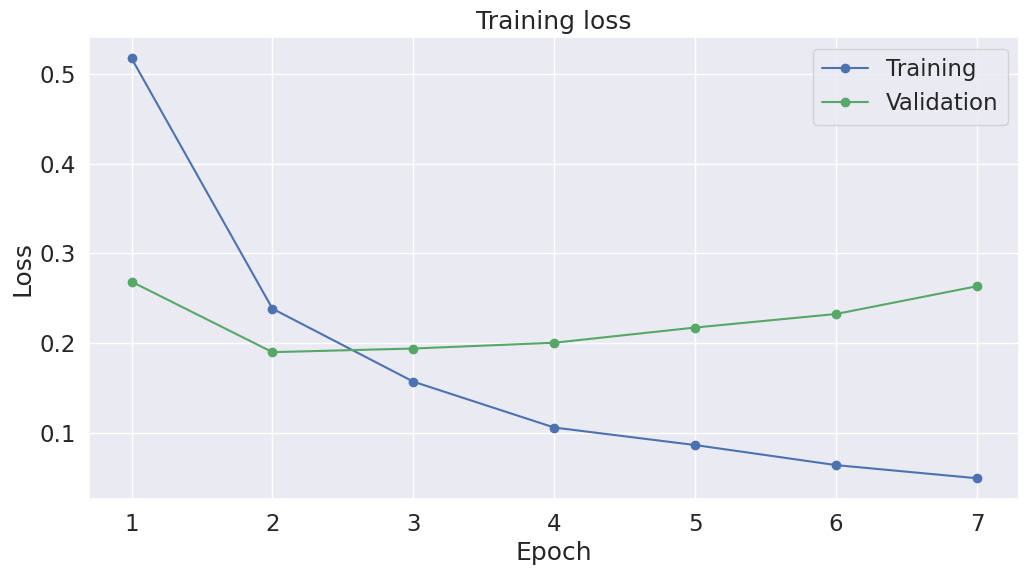

In [ ]:
# plot the train statistics stored in training_stats
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "darkgrid")

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = [12, 6]

df_stats = pd.DataFrame(data = training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Further learning: we can use callback function in pytorch to fetch the parameter values before the model is overfitted. https://dzlab.github.io/dl/2019/03/16/pytorch-training-loop/


## Evaluate the Model Performance

  * Evaluate the model performance using the validation dataset
  * Ealculating the confusion matrix, AUC, F-1 Score, MCC, etc.

Evaluate the model performance
  * calculate predictions and campare them to the true labels

In [ ]:
# apply the trained model to the validation dataset
# get the model predictions and compare the comparisons to the true labels
cls_model.eval()
predictions, labels = [], []
for step, batch in enumerate(valid_loader):
  input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
  attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
  label = batch['label'].to('cpu').numpy()

  with torch.no_grad():
    prediction = cls_model(input_ids, attention_mask)

  prediction = prediction.detach().cpu().numpy()
  predictions.append(prediction)
  labels.append(label)

<ipython-input-43-0a9305b5c0ef>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(input_ids, dtype = torch.long),
<ipython-input-43-0a9305b5c0ef>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(attention_mask, dtype = torch.long),


In [ ]:
# transfer the outcomes into np format
# Concatenate the tensors along the batch dimension
predictions_concatenated = np.concatenate(predictions)
# Flatten the concatenated array to one dimension
predictions_flat = predictions_concatenated.flatten()

labels_concatenated = np.concatenate(labels)
# Flatten the concatenated array to one dimension
labels_flat = labels_concatenated.flatten()


# put the predictions and labels into the same dataset
# df is &nbsp;the data set with which we evaluate the performance
df = np.array([predictions_flat, labels_flat]).T
df = pd.DataFrame(data=df, columns=["preds", "labels"])


df

,preds,labels
0,0.039961,0.0
1,0.042312,0.0
2,0.043686,0.0
3,0.959143,1.0
4,0.973963,1.0
...,...,...
395,0.971125,1.0
396,0.965067,1.0
397,0.774795,1.0
398,0.915825,1.0


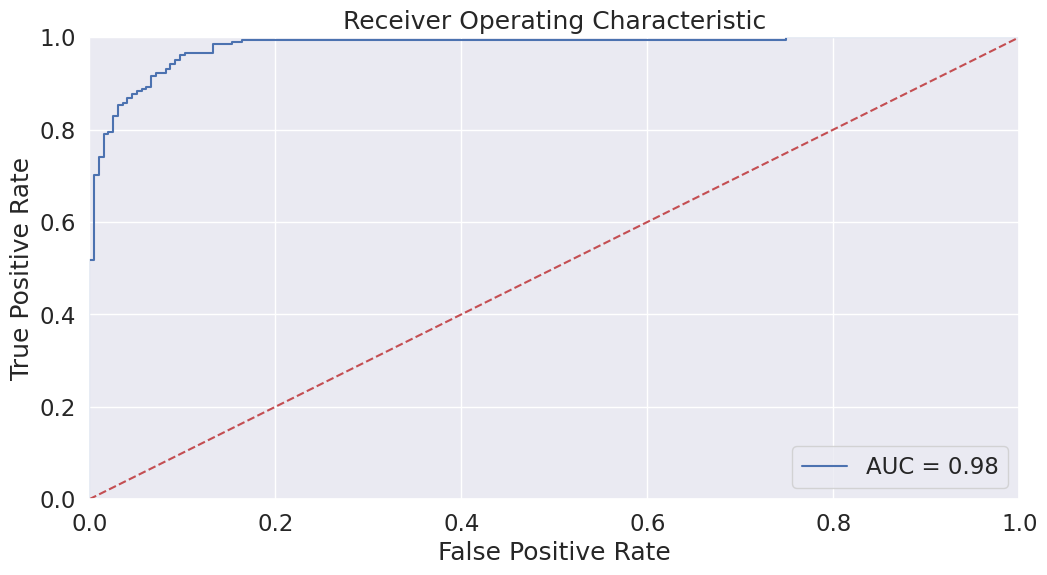

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(df['labels'], df['preds'])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix, matthews_corrcoef
confusion_matrix(df['labels'], df['preds'].round(0))
#can chatgpt add labels to make this look nice?

array([[176,  19],
       [  9, 196]])

In [ ]:
# true negative, false positive, false negative, true positive
tn, fp, fn, tp = confusion_matrix(df['labels'], df['preds'].round(0)).ravel()
print(" true negative:", tn, "false positive", fp, "\n",
      "false negative:", fn, "true positve:", tp)
print("accuracy:", (tn + tp)/(tn + fp + fp + tp))

 true negative: 176 false positive 19 
 false negative: 9 true positve: 196
accuracy: 0.9073170731707317


In [ ]:
# f1 score (review what this means again)
metrics.f1_score(df['labels'], df['preds'].round(0))

0.9333333333333333

In [ ]:
# naive f1 score: predicting every case as positive
raw_text['label'].mean()*2/(1 + raw_text['label'].mean())
#this means that: you want f1_score to be better than this naive score

0.6666666666666666

In [ ]:
# matthew's correlation coefficient
# why matthew's correlation coefficient is better than F1
# https://lettier.github.io/posts/2016-08-05-matthews-correlation-coefficient.html
matthews_corrcoef(df['labels'], df['preds'].round(0))

0.8608177539736676

In [ ]:
# test a specific example
text = input("please enter your text:")
encoded_text = tokenizer.encode_plus(text, max_length = 128, truncation = 'longest_first')
input_ids = torch.tensor([encoded_text['input_ids']]).to(device, dtype = torch.long)
attention_mask = torch.tensor([encoded_text['attention_mask']]).to(device, dtype = torch.long)
with torch.no_grad():
    prediction = cls_model(input_ids, attention_mask)
print("the predicted probability is:",prediction.item(),"\n",
      "the 'predicted label, when threshold is 0.5, is:", prediction.round().item())

please enter your text:Hated this mascara
the predicted probability is: 0.14678728580474854 
 the 'predicted label, when threshold is 0.5, is: 0.0


In [ ]:
# for all the observations that have true_label == 1,
# let's sort their predicted probabilities
df.loc[df['labels'] == 1, :].sort_values('preds')

,preds,labels
93,0.044277,1.0
231,0.199442,1.0
306,0.226095,1.0
34,0.293144,1.0
244,0.301709,1.0
...,...,...
33,0.974903,1.0
252,0.975496,1.0
272,0.975738,1.0
141,0.975817,1.0


In [ ]:
# see a specific observation
valid_raw.iloc[12,1]

"It wouldn't stay on my face while lying down, it kept sliding down."

In [ ]:
# on the other way around, for all the texts whose label == 0,
# let's sort their predicted probablities in descending order
df.loc[df['labels'] == 0, :].sort_values('preds', ascending = False)

,preds,labels
84,0.963801,0.0
282,0.947415,0.0
362,0.939298,0.0
30,0.923657,0.0
300,0.921202,0.0
...,...,...
94,0.035619,0.0
260,0.034698,0.0
262,0.033776,0.0
330,0.033614,0.0


In [ ]:
valid_raw.iloc[101,:]
valid_raw.iloc[101, 1]

'Disappointing results and wondering about returning.'

**Recap:**

  * Here we have combined BERT (good at transforming raw texts into meaningful numerical vectors) and Neural Network (good at classification)
  
  * We can easily transfer the method to other contexts and predict and measure other constructs of interests as long as we have proper labels for the constructs.

  * MTurk is a useful tool for developing the labels.  

## Save and Load a Trained Model



In [ ]:
# check the tutorial here:
# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch

import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
# if you want to save the trained model for later evaluation (not for training)
dir = "/content/drive/My Drive/BSAN 6300 FINAL PROJECT MRK ANALYTICS"
torch.save(cls_model.state_dict(), os.path.join(dir, 'bsan6300_trained_model.pt'))

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# later if you want to load the model and use it for evaluation (not trianing), do this:
# the_model = TheModelClass(*args, **kwargs), in our case
new_model = TextBERT()

# and the_model.load_state_dict(torch.load(PATH)), note that path is specified above
new_model.load_state_dict(torch.load("/content/drive/My Drive/BSAN 6300 FINAL PROJECT MRK ANALYTICS/bsan6300_trained_model.pt"))

## BERT and Cluster Analysis (based on Yelp Review)

  * Up to now we have been focusing on using BERT to generate a contextulized embedding of the raw input texts and feeding the sentence embeddings into a neural network for classification. The classification analysis helps us to check if the text has some attributes (e.g., a positive or negative review, manifiest of some constructs) and to what extent the texts have those attributes (i.e., the predicted probablity)


 * Now, let's think about another use of the contextualized sentence embedding. We can do cluster analysis on those embeddings and see if there are some patterns in it.


 * If we dong so with consumer review data, we can learn the representative reviews, keywords, opinions in each cluster, and by comparing the clusters derived from differnt locations, product categories, years, and review types. We can obtain a lot of insights!

















### Get intermediate output using **hook** function in Pytorch


In [ ]:
# to do cluster analysis, we first need to transfer the raw text review into embeddings
# we can leverage our trianed NN model to do so.
# Recall thate the first layer in our NN is a BERT model, whose job is exactly this.
# one benefit of using our traind NN rather than a commnon instance of raw BERT Model
# is that in our trained model, the BERT layer is also updated, its parameters
# has be trained to understand our general context (e.g., Yelp or Amazon reviews)
# and thus can encode our text better.

# then, our job is to feed the raw text into our trained NN.
# However, the final output of  our NN is a predicted probability
# we thus need to extract the intermediate output of the NN, i.e., the output of its first layer, the BERT layer
# here is a built-in function in Pytorch, call hook, to do the job-- extracting a NN's intermediate output

# bascially, hook is just a mark attached to a specific NN layer,
# telling the NN to store the intermediate output for later use
# here, we store the intermediate output in inter_out

inter_output = {}
def get_inter_output(name):
    def hook(model, input, output):
        inter_output[name] = output[0].detach()
    return hook

handle = cls_model.l1.register_forward_hook(get_inter_output('l1'))


In [ ]:
input_ids

In [ ]:
# run the BERT + NN model once
cls_model(input_ids,attention_mask)

In [ ]:
# to remove the hook
# handle.remove()

In [ ]:
# check the intermediate output
inter_output
inter_output['l1']

tensor([[[-0.5647, -0.0159,  0.0863,  ..., -0.2412,  0.8419, -0.5510],
         [-0.0189,  0.2498,  0.0781,  ...,  0.0949,  0.8217, -0.0430],
         [-0.6021,  0.0715,  0.5572,  ..., -0.8054,  0.4187,  0.1770],
         [ 0.7086,  0.5160,  0.0621,  ..., -0.6149,  0.2614, -0.9406],
         [ 0.7562,  0.1478, -0.0104,  ..., -0.1545, -0.3172, -0.3101]]],
       device='cuda:0')

In [ ]:
inter_output['l1'].shape

torch.Size([1, 5, 768])

In [ ]:
 # using the mean value of CLS and raw input token as sentence embedding
 inter_output["l1"][:, 0 : attention_mask.sum(), :].mean(dim = 1).shape

torch.Size([1, 768])

In [ ]:
# first, let's convert the raw review texts into contextualized numerical embeddings
# using encode_plus and BERT model

def text_to_embedding(index, dataset, max_len):
  # argument input: is the index to locate a specific text reivew
  # argument dataset: is the dataset that containing text reviews
  # argument max_len: is the max length of each review, for padding or truncating

  # extract the review text column in the dataset
  # per my experience, extract a column and then using pd.iloc[index] on the column
  # experience less bugs than pd.loc[index, 'column name']
  reviews = dataset.text

  # get the text review
  text = reviews.iloc[index]
  # transfer the text reivew into input_ids and attentino_mask that are required for BERT model
  encoded_text = tokenizer.encode_plus(
      text,
      max_length = max_len,
      # note that in some versions of transformer in you local machine, the code is
      # pad_to_max_length = True,
      # truncation_strategy = 'longest_first',
      # we might need to change the argument name a little to fit different version of transformers
      padding = "max_length",
      truncation = "longest_first",
      add_special_tokens = True,
      return_tensors = "pt"
  )
  # make the input_ids and attention_mask into torch tensors,
  # which will make the late use of BERT Model easier
  # note that we use to(device) to deliever the data to GPU,
  # so that they can be used in model_yelp, which is alread in GPU
  input_ids = torch.tensor(encoded_text['input_ids'], dtype = torch.long).to(device)
  attention_mask = torch.tensor(encoded_text['attention_mask'], dtype = torch.long).to(device)

  # transfer the input_ids and attention_mask into sentence embeddings by
  # putting them into our trained NN model: mddel_yelp
  cls_model(input_ids, attention_mask)


  text_embedding = inter_output["l1"][:, 0 : attention_mask.sum(), :].mean(dim = 1)
  # again, we can choose to use differnt outputs from the BERT Model as the embeddings of the sentence/review
  # here, we use the mean value of non-padded tokens from the last self-attention layer of BERT

  return text_embedding



In [ ]:
# test the function, focusing on the output of its shape
text_to_embedding(32, valid_raw, 128).shape


<ipython-input-86-db209c7d36c0>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoded_text['input_ids'], dtype = torch.long).to(device)
<ipython-input-86-db209c7d36c0>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(encoded_text['attention_mask'], dtype = torch.long).to(device)


torch.Size([1, 768])

### Get intermediate output using layer





Indeed, we can directly use the trained BERT model (the first layer of cls_model: cls_model.l1) to get the embedding

In [ ]:
# check if the inter_output from hook is same as the cls_model.l1
inter_output['l1'][:,0,:]==cls_model.l1(input_ids, attention_mask).last_hidden_state[:,0,:]

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [ ]:
# or if we want to use CLS embedding as the sentence embedding (note that CLS has gone through a tanh activation layer)
cls_model.l1(input_ids, attention_mask).pooler_output

tensor([[-2.7581e-01, -5.6584e-01, -9.9333e-01,  7.4577e-01,  9.6381e-01,
         -6.2359e-01,  5.7958e-01,  3.4869e-01, -9.9203e-01, -8.9146e-01,
         -8.9957e-01,  9.9726e-01,  2.0474e-01,  8.3727e-01,  1.5194e-02,
         -8.4560e-01, -9.3185e-01, -3.7058e-01,  1.7876e-01,  2.9711e-01,
          4.9735e-01,  1.0000e+00, -8.1322e-01,  4.2335e-01,  5.1860e-01,
          9.9973e-01, -8.2738e-01,  1.0553e-01,  4.7654e-01,  3.3202e-01,
         -4.3964e-01,  2.7635e-01, -7.9561e-01, -1.0150e-01, -9.9822e-01,
         -6.6932e-01,  5.7844e-01,  1.3165e-01, -2.3700e-01,  1.1103e-01,
         -2.5756e-01,  1.2236e-01,  9.9753e-01,  7.3402e-01,  7.5034e-01,
         -1.2996e-01, -1.0000e+00,  3.8263e-01, -2.8952e-02,  9.8431e-01,
          9.9080e-01,  9.9463e-01,  2.8021e-01,  4.3581e-01,  4.7609e-01,
         -9.5816e-01,  3.8212e-01,  3.0217e-01, -2.0805e-01, -4.4128e-01,
         -4.3149e-01,  5.4541e-01, -9.9590e-01, -1.9801e-01,  9.9941e-01,
          9.6266e-01, -3.8306e-01, -3.

In [ ]:
# define the text_to_embedding function again
def text_to_embedding(index, dataset, max_len):
  reviews = dataset.text
  text = reviews.iloc[index]
  encoded_text = tokenizer.encode_plus(
      text,
      max_length = max_len,
      padding = "max_length",
      truncation = "longest_first",
      add_special_tokens = True,
      return_tensors = "pt"
  )
  input_ids = torch.tensor(encoded_text['input_ids'], dtype = torch.long).to(device)
  attention_mask = torch.tensor(encoded_text['attention_mask'], dtype = torch.long).to(device)
  output = cls_model.l1(input_ids, attention_mask)
  text_embedding = output.pooler_output # CLS token as sentence embedding

  # again, we can choose to use differnt outputs from the BERT Model as the embeddings of the sentence/review
  # here, we use the mean value of non-padded tokens from the last self-attention layer of BERT
  # text_embedding = output.last_hidden_state[:, 1 : attention_mask.sum(), :].mean(dim = 1)

  return text_embedding



In [ ]:
# use a loop to embed a number of reviews in the raw dataset
review_embeddings = []
with torch.no_grad():
  for index in range(20):
    review_embedding = text_to_embedding(index, valid_raw.loc[valid_raw['label'] == 1,:], 128)
    review_embeddings.append(review_embedding)

# note that you can filter specific groups of obs in the raw dataset for further analysis
# for instance, I only use positive reviews in the sample here.
# later, I can find clusters in ONLY positive reviews, which could help me summarize
# the main factors that make consumers give a positive review
# replace the code below into the loop above
#





<ipython-input-90-7db2b7ebd4e2>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoded_text['input_ids'], dtype = torch.long).to(device)
<ipython-input-90-7db2b7ebd4e2>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(encoded_text['attention_mask'], dtype = torch.long).to(device)


In [ ]:
len(review_embeddings)

20

In [ ]:
# transfer the list of sentence embedings into a numpy array
review_embeddings = torch.cat(review_embeddings, 0)
review_embeddings = review_embeddings.to('cpu')
review_embeddings = review_embeddings.numpy()

In [ ]:
type(review_embeddings)

numpy.ndarray

In [ ]:
# do the cluster analysis
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np


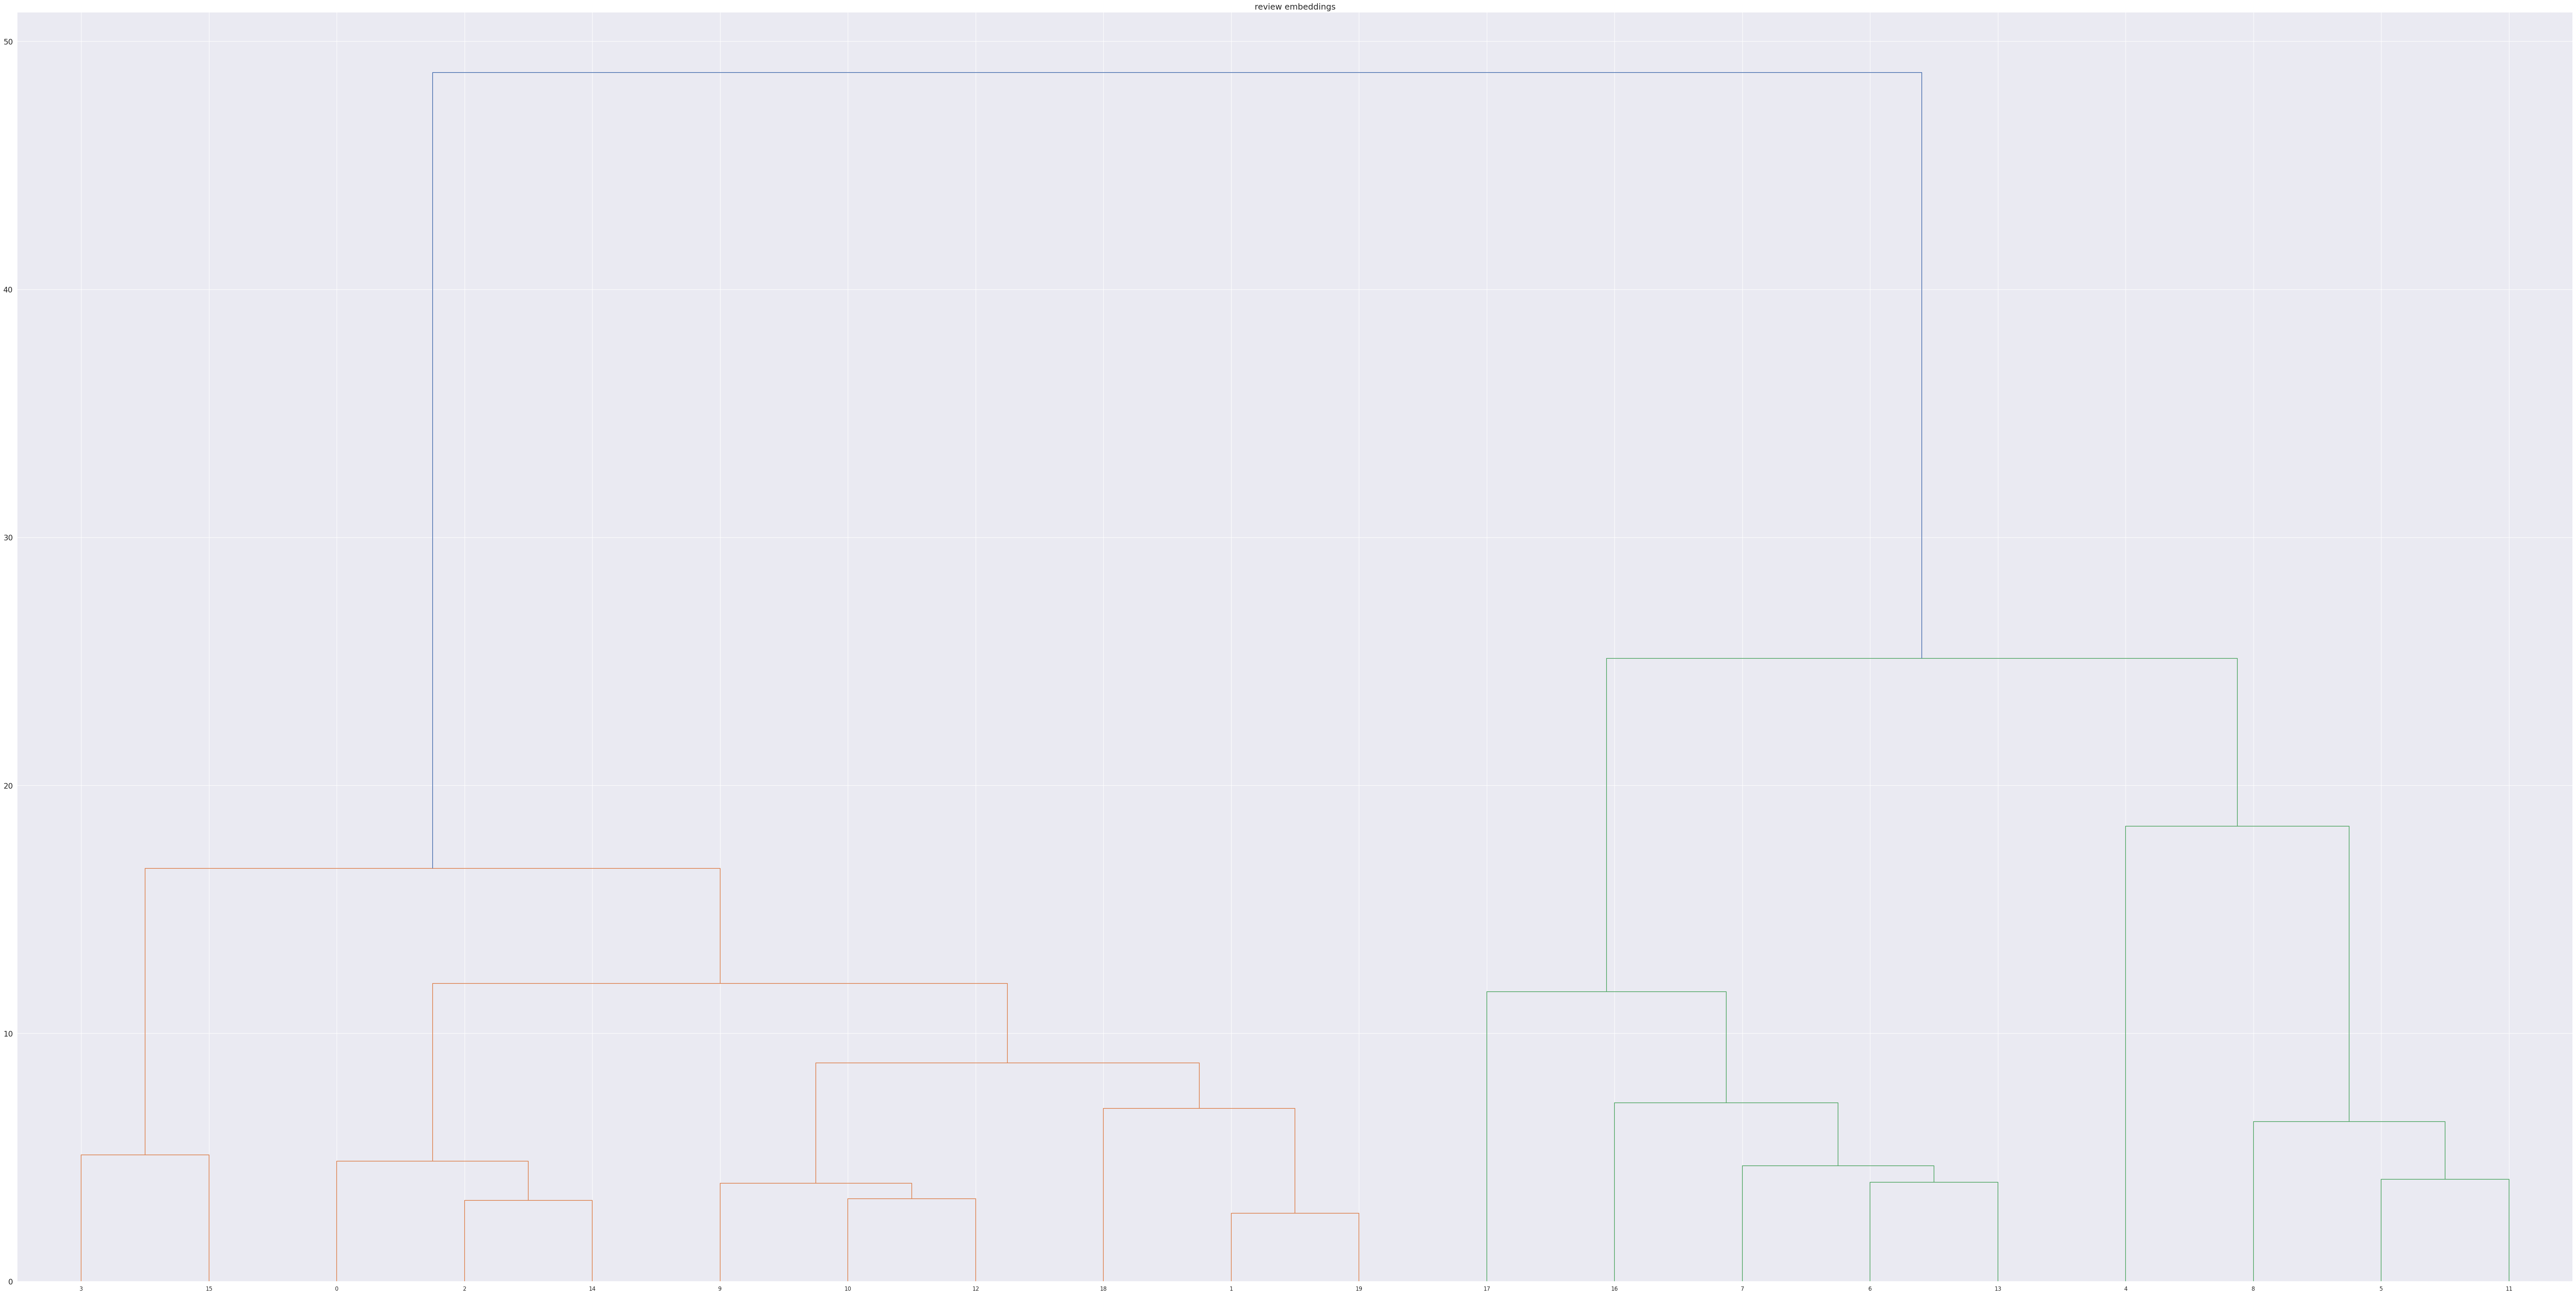

In [ ]:
# use the dendrogram graph to identify the clusters
import scipy.cluster.hierarchy as shc
plt.figure(figsize = (100, 50))
plt.title("review embeddings")
dend = shc.dendrogram(shc.linkage(review_embeddings, method = "ward"))

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
# specify the n_clusters you want
number_of_clusters = 3

In [ ]:
cluster = AgglomerativeClustering(n_clusters = number_of_clusters, affinity = 'euclidean', linkage = 'ward')

In [ ]:
cluster_id = cluster.fit_predict(review_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [ ]:
cluster_id

array([5, 2, 5, 4, 3, 1, 0, 0, 1, 2, 2, 1, 2, 0, 5, 4, 0, 0, 2, 2])

In [ ]:
sample_review = valid_raw.iloc[0:20 ,:]
sample_review['cluster_id'] = cluster_id

<ipython-input-201-576a3a2d9e2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_review['cluster_id'] = cluster_id


In [ ]:
sample_review

,label,text,cluster_id
1278,0,This came with no instructions on how to use. ...,5
652,0,I bought this product and within 2 months I ha...,2
8544,0,Very sharp with no blade protection. The item ...,5
14397,1,Very nice material and dont loose stretch.,4
11056,1,Love these sponges. I’ve repurchased them for ...,3
18525,0,The DVD didn't work. I thought I was purchasin...,1
14617,1,"I have long, relatively fine hair. I like thes...",0
19146,1,Love the classics,0
4966,0,I had a favorite self tanner that I absolutely...,1
18519,0,Pretty sure it’s fake. No Disney magic points ...,2


In [ ]:
sample = sample_review.groupby('cluster_id').apply(pd.DataFrame.sample, 1).iloc[:,:]


In [ ]:
sample['text']

cluster_id       
0           14617    I have long, relatively fine hair. I like thes...
1           7831     I don’t know if I got a bad set or what, but t...
2           5687     Adds volume & thickness with one or two coats....
3           11056    Love these sponges. I’ve repurchased them for ...
4           12521    I purchased two packages of this product, and ...
5           1278     This came with no instructions on how to use. ...
Name: text, dtype: object

In [ ]:
sample = sample_review.groupby('cluster_id').apply(pd.DataFrame.sample, 1)

In [ ]:
print("Cluster 1:","\n",sample.iloc[0,1], "\n")
print("Cluster 2:","\n",sample.iloc[1,1], "\n")
print("Cluster 3:","\n",sample.iloc[2,1], "\n")
print("CLuster 4:","\n",sample.iloc[3,1], "\n")
print("Cluster 5:","\n",sample.iloc[4,1], "\n")

NameError: name 'sample' is not defined